# Tutorial: GPFA (Gaussian Process Factor Analysis)

Gaussian-process factor analysis (GPFA) is a dimensionality reduction method
[1] for neural trajectory visualization of parallel spike trains. GPFA applies
factor analysis (FA) to time-binned spike count data to reduce the
dimensionality and at the same time smoothes the resulting low-dimensional
trajectories by fitting a Gaussian process (GP) model to them.

The input consists of a set of trials ($Y$), each containing a list of spike
trains (N neurons). The output is the projection ($X$) of the data in a space
of pre-chosen dimensionality $x_{dim} < N$.

Under the assumption of a linear relation (transform matrix $C$) between the
latent variable $X$ following a Gaussian process and the spike train data $Y$ with
a bias $d$ and a noise term of zero mean and (co)variance $R$ (i.e.,
$Y = C X + d + \mathcal{N}(0,R)$), the projection corresponds to the
conditional probability $E[X|Y]$.
The parameters $(C, d, R)$ as well as the time scales and variances of the
Gaussian process are estimated from the data using an expectation-maximization
(EM) algorithm.

Internally, the analysis consists of the following steps:

0. bin the spike train data to get a sequence of $N$ dimensional vectors of spike counts in respective time bins, and choose the reduced dimensionality $x_{dim}$

1. expectation-maximization for fitting of the parameters $C, d, R$ and the time-scales and variances of the Gaussian process, using all the trials provided as input (c.f., `gpfa_core.em()`)

2. projection of single trials in the low dimensional space (c.f., `gpfa_core.exact_inference_with_ll()`)

3. orthonormalization of the matrix $C$ and the corresponding subspace, for visualization purposes: (c.f., `gpfa_core.orthonormalize()`)


## 1. Idea of This Tutorial

This tutorial illustrates the usage of the `gpfa.GPFA()` class implemented in elephant, through its applications to synthetic spike train data, of which the ground truth low-dimensional structure is known.

The examples were inspired by the supplementary material of [2]

### 1.1. Generation of synthetic spike trains

A set of spike trains are generated as follows.
First, a time series of either a 2-dimensional harmonic oscillator (Section 2) or a 3-dimensional Lorentz system (Section 3; the "standard" parameter values as seen in https://en.wikipedia.org/wiki/Lorenz_system are used) is projected into a high-dimensional space (as high dimension as the desired number of parallel spike trains) via a random projection.
Then the resulting high-dimensional time series serves as time-dependent rates for an inhomogeneous multivariate Poisson process.
Finally, multiple realizations of this Poisson process, which mimic spike trains from multiple trials, serve as input data to the GPFA.

Below are the functions used for spike train generation:

In [1]:
import numpy as np
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process


def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """    
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float 
        Initial values in three dimensional space.
    angular_frequency : float 
        Angular frequency in 1/ms.
    
    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """ 
    
    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))


def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05,
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """
    
    Parameters
    ----------
    dt : 
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0, z0 : float 
        Initial values in three dimensional space
    sigma, rho, beta : float 
        Parameters defining the lorenz attractor
    tau : characteristic timescale in ms
    
    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (3, num_steps) np.ndarray
        Integrated three-dimensional trajectory (x, y, z) of the Lorenz attractor
    """
    def _lorenz_ode(point_of_interest, timepoint, sigma, rho, beta, tau):
        """
        Fit the model with `spiketrains` data and apply the dimensionality
        reduction on `spiketrains`.

        Parameters
        ----------
        point_of_interest : tuple
            Tupel containing coordinates (x,y,z) in three dimensional space. 
        timepoint : a point of interest in time
        dt : 
            Integration time step in ms.
        num_steps : int
            Number of integration steps -> max_time = dt*(num_steps-1).
        sigma, rho, beta : float 
            Parameters defining the lorenz attractor
        tau : characteristic timescale in ms

        Returns
        -------
        x_dot, y_dot, z_dot : float 
            Values of the lorenz attractor's partial derivatives
            at the point x, y, z.
        """

        x, y, z = point_of_interest

        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot

    assert isinstance(num_steps, int), "num_steps has to be integer"
    
    t = dt*np.arange(num_steps)
    poi = (x0, y0, z0)
    return t, odeint(_lorenz_ode, poi, t, args=(sigma, rho, beta, tau)).T


def random_projection(data, embedding_dimension, loc=0, scale=None):
    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray 
       Random (normal) projection of input data, shape=(dim, N)
       
    See Also
    --------
    np.random.normal()
    
    """
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """    
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep : 
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).
        
    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.
    
    """
    
    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            spiketrains_per_trial.append(inhomogeneous_poisson_process(anasig_inst_rate))
        spiketrains.append(spiketrains_per_trial)
        
    return spiketrains

## 2. Harmonic Oscillator Example

In this first example we apply the GPFA to spike train data derived from dynamics of a harmonic oscillator defined in a 2-dimensional latent variable space. The aim is to extract these 2-dimensional latent dynamics from the spike train data.

### 2.1. Generate synthetic spike train data
Here we generate 50-dimensional synthetic spike train data based on a trajectory of a 2-dimensional harmonic oscillator, as described in Section 1.1.

In [2]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

Let's see how the trajectory and the spike trains look like.

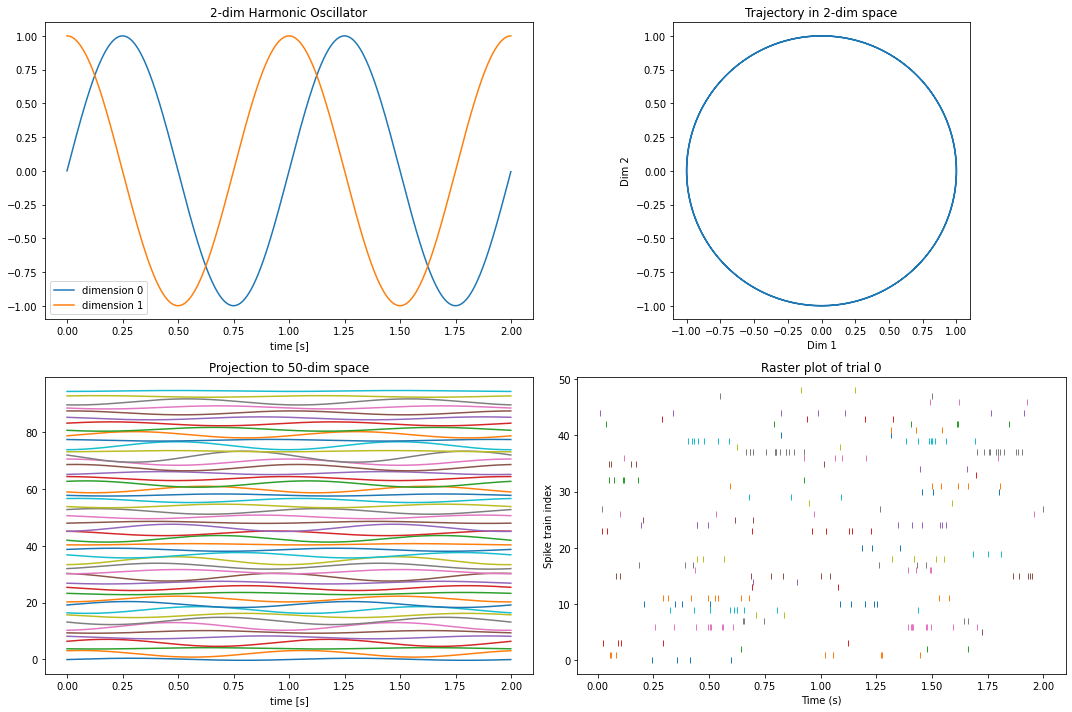

In [3]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

Thus, we have generated 50-dimensional spike train data, derived from 2-dimensional latent dynamics, i.e., two cycles of circular rotation.

### 2.2. Apply GPFA to the generated data
Now we try to extract the original latent dynamics from the generated spike train data, by means of GPFA.

We first initialize an instance of the `gpfa.GPFA()` class.
One can specify some parameters for model fitting at this timing.
Here we set the size of the bin for spike train binning to 20 ms, and the dimensionality of latent variables to 2.

In [4]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

Then we call the `fit()` method of the class, with the generated spike train data as input.
This fits a GPFA model to the given data, yielding estimates of the model parameters that best explain the data, which are stored in the `params_estimated` attribute of the class.
Here we use the first half of the trials for fitting.

In [5]:
gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
print(gpfa_2dim.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 430 EM iterations.)
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


Then we transform the spike trains from the remaining half of the trials into tranjectories in the latent variable space, using the `transform()` method.

In [6]:
trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])

Let's see how the extracted trajectories look like.

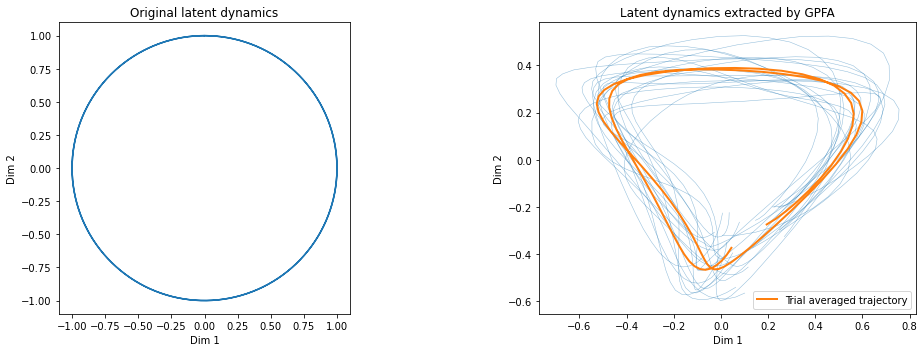

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

GPFA successfuly exatracted, as the trial averaged trajectory, the two cycles of rotation in 2-dimensional latent space from the 50-dimensional spike train data.

In the above application we split the trials into two halves and performed fitting and transforming separately on these two sets of trials.
One can also simply perform fitting and transforming on the whole dataset to obtain latent trajectories for all trials.
In such a senario, the `fit_transform()` method can be used to perform the fitting and transforming at once, as shown in the example below.

Initializing parameters using factor analysis...

Fitting GPFA model...


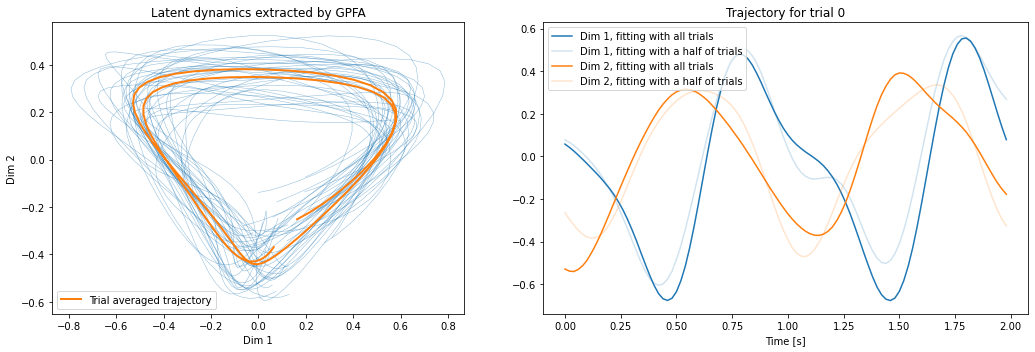

In [8]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(spiketrains_oscillator)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

We obtain almost the same latent dynamics, but single trial trajectories are slightly modified owing to an increased amount of the data used for fitting.

## 3. Lorentz System Example

### 3.1. Generate sysnthetic spike train data
Now we move on to the next example.
Here we generate 50-dimensional synthetic spike train data based on a trajectory of a 3-dimensional Lorentz system.
Note that, as we want to adopt a part of the trajectory where the double-wing structure of the attractor is fully developed as "trial", we drop off an initial part of the trajectory as "transient".

In [9]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)

Let's plot the obtained trajectory and the spike trains.

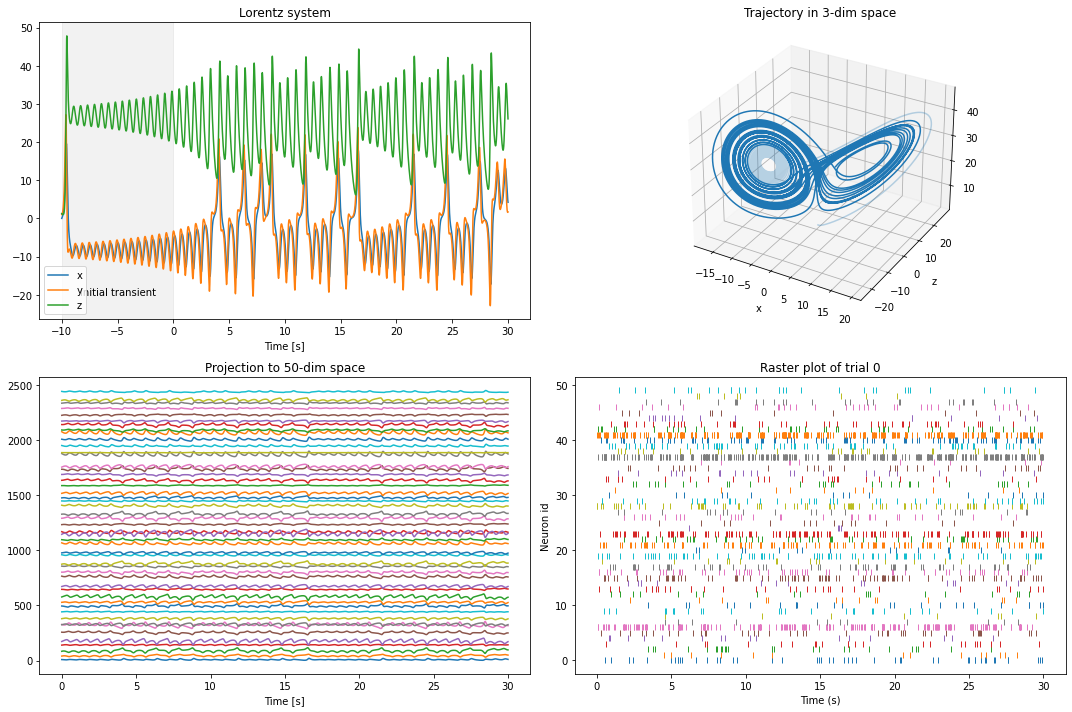

In [10]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

The 3-dimensional latent trajectory exhibit a charactistic structure of the Lorentz attractor: intermittent switching between rotations around two foci, which is difficult to recognize in the spike train data derived from it.

### 3.2. Apply GPFA to the generated data
Now we apply the GPFA to the data, with the same bin size as before but with a latent dimensionality of 3 this time. We fit and transform all trials at once using the `fit_transform()` method.

In [11]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

Initializing parameters using factor analysis...

Fitting GPFA model...


Let's see how well the method worked in this case.

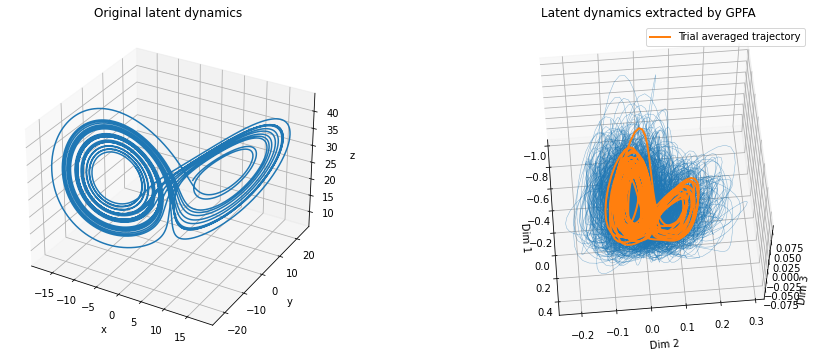

In [12]:
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

Again, the characteristic structure of the original latent dynamics was successfully extracted by GPFA.

Let's take a closer look into the time series of the extracted latent variables, and compare them with the x, y, and z time series of the original Lorentz system.

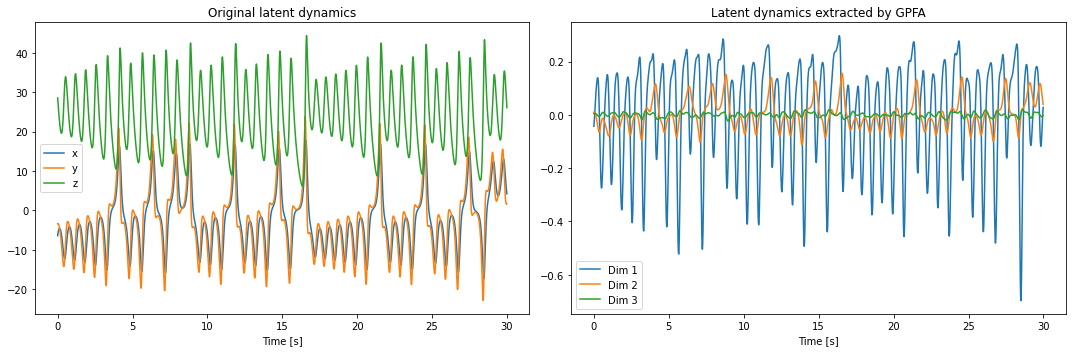

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=labels[i])
ax1.legend()

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Time [s]')
for i, x in enumerate(average_trajectory):
    ax2.plot(np.arange(len(x))*0.02, x, label=f'Dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()

Any of the extracted dimension does not correspond solely to a single dimension of the original latent dynamics. In addition, the amplitude of Dim 3 is much smaller than the other two, reflecting the fact that the dimensionality of the original latent dynamics is close to 2, evident from the very similar time series of $x$ and $y$ of the original latent dynamics.

## 4. Cross-validation

The `gpfa.GPFA()` class is compatible to the cross-validation functions of `sklearn.model_selection`, such that users can perform cross-validation to search for a set of parameters yielding best performance using these functions.

Here we demonstrate a use of the `sklearn.model_selection.cross_val_score()` function to search for an optimal dimension of the latent variables for the spike train data derived from the Lorentz system.
We vary the dimensionality between 1 and 5, and perform 3-fold cross-varidation for each dimensionality value, to obtain an estimate the log-likelihood of the data under the GPFA model with the given dimensionality.

_Note: The following step is time consuming._

In [14]:
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
    cv_log_likelihoods = cross_val_score(gpfa_cv, spiketrains_lorentz, cv=3, n_jobs=3, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods)) 

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.6min finished


Let's plot the obtained log-likeliyhood as a function of the dimensionality.

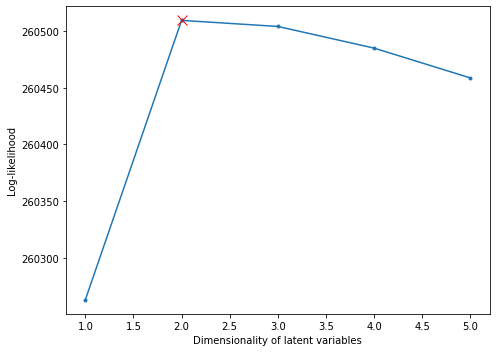

In [15]:
f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()

The red cross denotes the maximum log-likelihood, which is taken at the dimensionality of 2.
This means that the best-fitting GPFA model is the one with a latent dimensionality of 2, which does not match the ground-truth dimensionality of 3 in this example.
This "underestimate" of dimensionality would possibly be becouse the dimensionality of the Lorentz attractor is very close to 2 (to be precise, its Hausdorff dimension is estimated to be 2.06... [3]), and the stochastic "encoding" of the trajectory by spike trains would not allow for reprsenting such a subtle excess of dimensionality above 2.

# References

[1] Yu MB, Cunningham JP, Santhanam G, Ryu SI, Shenoy K V, Sahani M (2009) Gaussian-process factor analysis for low-dimensional single-trial analysis of neural population activity. J. Neurophysiol. 102:614-635.

[2] Pandarinath, C. et al. (2018) Inferring single-trial neural population dynamics using sequential auto-encoders. Nat. Methods 15:805–815.

[3] Viswanath, D (2004) The fractal property of the Lorenz attractor. Physica D 190(1-2):115-128.

In [16]:
print(scipy.__version__)

NameError: name 'scipy' is not defined

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 335 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 440 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 425 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA m